In [1]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.distributed as dist
import torch.nn as nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import VOCDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, DistributedSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.multiprocessing as mp
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.cuda.amp import autocast, GradScaler
from typing import Dict
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image
import xml.etree.ElementTree as ET
import collections
from torchvision import transforms
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

#-------------------------------------------------------------------------------------JUPYTER NOTEBOOK SETTINGS-------------------------------------------------------------------------------------
from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))   

C:\Users\Ciprian-Florin Ifrim\AppData\Local\Temp\ipykernel_9084\2632810313.py:35: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
CUSTOM_CLASSES = {"name": 1, "value": 2, "x-axis": 3, "y-axis": 4, "plot":5}
PASSTHROUGH_FIELDS = ['folder', 'filename', 'source', 'size', 'segmented', 'object']

def transform_voc_target(target, original_width, original_height, new_width, new_height):
    boxes = []
    labels = []
    width_ratio = new_width / original_width
    height_ratio = new_height / original_height
    for obj in target["annotation"]["object"]:
        class_name = obj[0]
        bbox = obj[-1]
        # Normalize the bounding box coordinates
        boxes.append([float(bbox["xmin"]) * width_ratio, float(bbox["ymin"]) * height_ratio,
                      float(bbox["xmax"]) * width_ratio, float(bbox["ymax"]) * height_ratio])
        if class_name in CUSTOM_CLASSES:
            labels.append(CUSTOM_CLASSES[class_name])
        else:
            print(f"Warning: {class_name} is not in CUSTOM_CLASSES")
            # you might want to handle this situation better
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    # Hash the filename to a unique numeric value
    image_id = torch.tensor([hash(target["annotation"]["filename"])])
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    return target

class CustomVOCDetection(Dataset):
    def __init__(self, root, dataset_name, image_set='train', transforms=None, classes=None):
        self.root = root
        self.classes = classes
        
        voc_root = os.path.join(self.root, 'VOCdevkit', dataset_name)
        image_dir = os.path.join(voc_root, 'JPEGImages')
        annotation_dir = os.path.join(voc_root, 'Annotations')

        if not os.path.isdir(voc_root):
            raise RuntimeError('Dataset not found or corrupted.')

        splits_dir = os.path.join(voc_root, 'ImageSets', 'Main')
        
        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        self.transforms = transforms

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if len(img.getbands()) != 3:
            print(f"Image at {self.images[index]} does not have 3 channels after conversion to RGB")

        # Get the original image size
        original_width, original_height = img.size

        target = self.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())

        if self.transforms is not None:
            img = self.transforms(img)

            # The transformed image size
            # Calculate new size preserving aspect ratio
            if original_width <= original_height:
                new_height = 512
                new_width = int(original_width * (new_height / original_height))
            else:
                new_width = 512
                new_height = int(original_height * (new_width / original_width))

            target = transform_voc_target(target, original_width, original_height, new_width, new_height)

        return img, target

    def __len__(self):
        return len(self.images)

    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag in PASSTHROUGH_FIELDS:
                voc_dict[node.tag] = [def_dic[ind][0] if len(def_dic[ind]) == 1 else def_dic[ind] for ind in def_dic]
            else:
                voc_dict[node.tag] = {ind: def_dic[ind][0] if len(def_dic[ind]) == 1 else def_dic[ind] for ind in def_dic}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

def collate_fn(batch):
    return tuple(zip(*batch))

In [3]:
# Data processing
data_transforms = transforms.Compose([
    transforms.Resize(512),                                            
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
val_data = CustomVOCDetection(
    root="pascal_voc_datasets/",
    dataset_name="PlotsEnchanced_Original_NoAugmentation",
    image_set="test",  # assuming the set name is 'validation'
    transforms=data_transforms,
    classes=CUSTOM_CLASSES 
)

data_loader = DataLoader(val_data, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [6]:
# Load the pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier with a new one
CUSTOM_CLASSES = {"name": 1, "value": 2, "x-axis": 3, "y-axis": 4, "plot":5}
num_classes = len(CUSTOM_CLASSES) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load saved model
model_folder = "pytorch_rcnn_models/"
model_name = "FINAL-v2_rcnn_batch-16_epoch-40_full-enchanced-original_non-augmented"
model_extension = ".pt"
model.load_state_dict(torch.load(model_folder + model_name + model_extension))

<All keys matched successfully>

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Switch the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
from pycocotools.coco import COCO
import json

# These will hold the annotations
ground_truth_annotations = []
predicted_annotations = []

for idx, (images, targets) in enumerate(data_loader):
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Moving targets to the device

    with torch.no_grad():
        predictions = model(images)

    # Iterate through each image in the batch
    for img_idx, (target, prediction) in enumerate(zip(targets, predictions)):
        # Ground Truth Annotations
        gt_boxes = target["boxes"].tolist()
        gt_labels = target["labels"].tolist()
        for i, box in enumerate(gt_boxes):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            ground_truth_annotations.append({
                "image_id": idx * len(images) + img_idx,
                "bbox": [x_min, y_min, width, height], # bounding box in [x_min, y_min, width, height] format
                "area": width * height, # area of the bounding box
                "iscrowd": 0, # since all objects are individual, iscrowd can be set to 0
                "category_id": gt_labels[i],
                "id": len(ground_truth_annotations),
            })

        # Predicted Annotations
        pred_boxes = prediction["boxes"].tolist()
        pred_labels = prediction["labels"].tolist()
        pred_scores = prediction["scores"].tolist()
        for i, box in enumerate(pred_boxes):
            x_min, y_min, x_max, y_max = box
            predicted_annotations.append({
                "image_id": idx * len(images) + img_idx,
                "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                "score": pred_scores[i],
                "category_id": pred_labels[i],
                "id": len(predicted_annotations),
            })

# Assuming you have a list of image file paths in 'val_data.images'
ground_truth_data = {
    "images": [{"id": i, "file_name": os.path.basename(img_path)} for i, img_path in enumerate(val_data.images)],
    "annotations": ground_truth_annotations,
    "categories": [{"id": v, "name": k} for k, v in CUSTOM_CLASSES.items()]
}

coco_folder = "coco_predictions/"
with open(coco_folder + model_name + "_(ground_truth).json", 'w') as f:
    json.dump(ground_truth_data, f)

# Writing the predictions
with open(coco_folder + model_name + "_(predictions).json", 'w') as f:
    json.dump(predicted_annotations, f)  # Writing directly as a list

In [13]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load the ground truth and predictions
coco_gt = COCO(coco_folder + model_name + "_(ground_truth).json")
coco_pred = coco_gt.loadRes(coco_folder + model_name + "_(predictions).json")

# Create the evaluation object
coco_eval = COCOeval(coco_gt, coco_pred, 'bbox')

# Run the evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.72s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.15s).
Accumulating evaluation results...
DONE (t=10.91s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.979
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.983
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.982
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.987
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=25.26s).
Accumulating evaluation results...
DONE (t=8.92s).
 Average Precision  (AP) @[ IoU=0.75:0.75 | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75:0.75 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75:0.75 | area=medium | maxDets=100 ] = 0.975
 Average Precision  (AP) @[ IoU=0.75:0.75 | area= large | maxDets=100 ] = 0.990
 Average Recall     (AR) @[ IoU=0.75:0.75 | area=   all | maxDets=  1 ] = 0.987
 Average Recall     (AR) @[ IoU=0.75:0.75 | area=   all | maxDets= 10 ] = 0.993
 Average Recall     (AR) @[ IoU=0.75:0.75 | area=   all | maxDets=100 ] = 0.993
 Average Recall     (AR) @[ IoU=0.75:0.75 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.75:0.75 | area=medium | maxDet

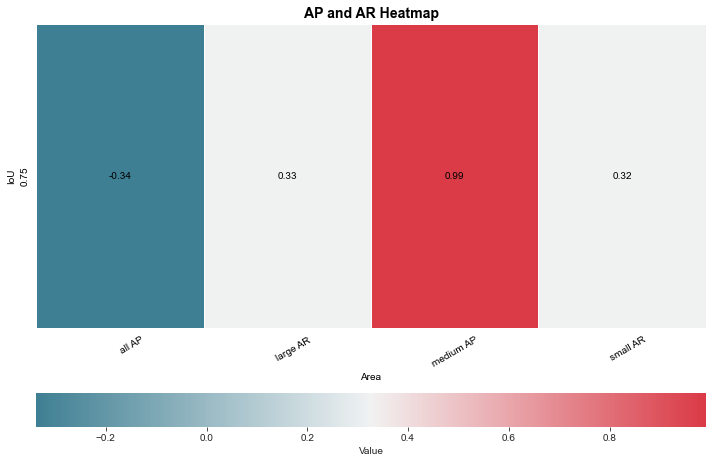

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=26.36s).
Accumulating evaluation results...
DONE (t=8.96s).
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=  1 ] = 0.992
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets= 10 ] = 0.999
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.999
 Average Recall     (AR) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=medium | maxDet

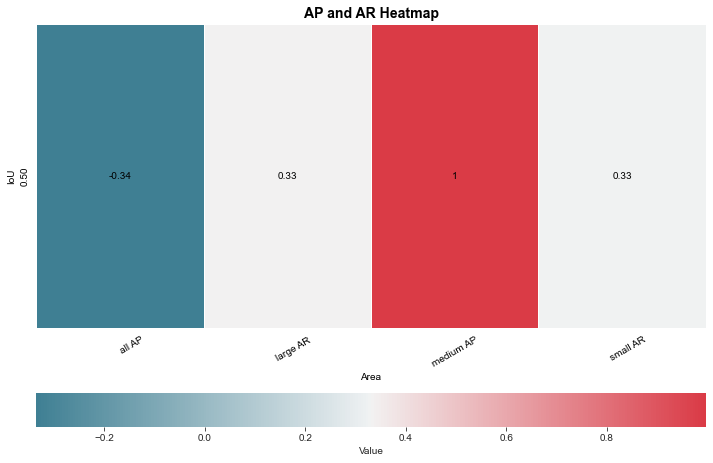

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.56s).
Accumulating evaluation results...
DONE (t=11.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.979
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.983
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.982
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.987
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.987
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDe

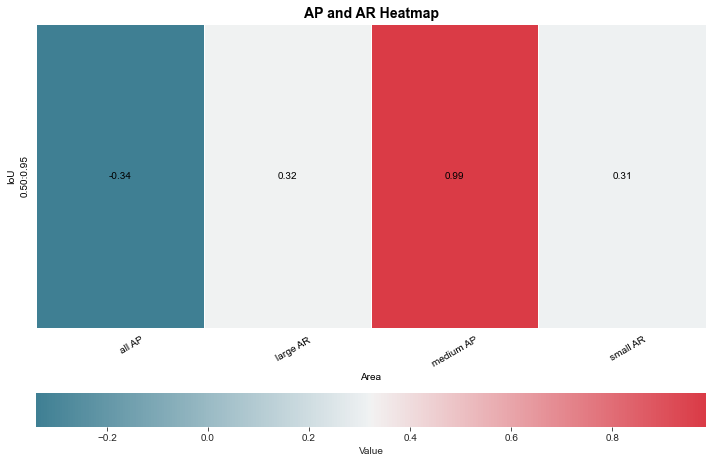

In [12]:
def evaluate(iou_thresholds):
    coco_eval.params.iouThrs = iou_thresholds
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats

def plot_heatmap(stats, iou_label):
    data = {
        'IoU': iou_label * 12,
        'Area': ['all', 'all', 'all', 'small', 'small', 'small', 'medium', 'medium', 'medium', 'large', 'large', 'large'],
        'Metric': ['AP'] * 3 + ['AR'] * 3 + ['AP'] * 3 + ['AR'] * 3,
        'Value': stats[:12]
    }

    df = pd.DataFrame(data)
    heatmap_data = df.pivot_table(index=['IoU'], columns=['Area', 'Metric'], values='Value')

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    plt.figure(figsize=(12, 8))
    sns.set_style("white")
    sns.heatmap(heatmap_data, cmap=cmap, annot=True,
                linewidths=0.5, 
                cbar_kws={'label': 'Value', "orientation": "horizontal", "pad": 0.15},
                annot_kws={'size': 10, 'weight': 'normal', 'color': 'black'})

    plt.title("AP and AR Heatmap", fontsize=14, weight='bold', loc='center', color='black')
    plt.xlabel('Area', fontsize=10, color='black')
    plt.ylabel('IoU', fontsize=10, color='black')

    xticks = np.arange(len(heatmap_data.columns)) + 0.65
    plt.xticks(ticks=xticks, labels=[f"{col[0]} {col[1]}" for col in heatmap_data.columns],
               fontsize=10, color='black', rotation=30, ha='right')

    plt.yticks(fontsize=10, color='black')
    plt.show()

# Set the area ranges
coco_eval.params.areaRng = [[0 **2, 1e5 **2], [0 **2, 32 **2], [32 **2, 96 **2], [96 **2, 1e5 **2]]

# Run evaluations and plot heatmaps for different IoU thresholds
iou_labels = ['0.75', '0.50', '0.50:0.95']
iou_thresholds_list = [[0.75], [0.50], [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]]

for iou_label, iou_thresholds in zip(iou_labels, iou_thresholds_list):
    stats = evaluate(iou_thresholds)
    plot_heatmap(stats, [iou_label])


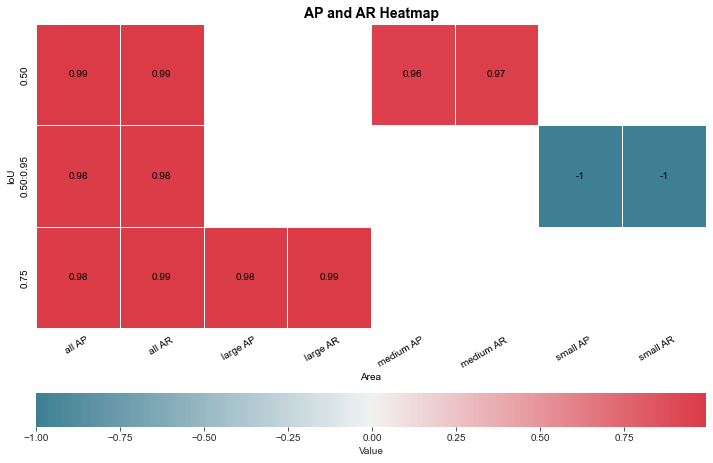

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extracting the stats
stats = coco_eval.stats

data = {
    'IoU': ['0.50:0.95', '0.50', '0.75', '0.50:0.95', '0.50', '0.75', '0.50:0.95', '0.50', '0.75',
            '0.50:0.95', '0.50', '0.75'],
    'Area': ['all', 'all', 'all', 'small', 'medium', 'large',
             'all', 'all', 'all', 'small', 'medium', 'large'],
    'Metric': ['AP'] * 6 + ['AR'] * 6,
    'Value': stats[:12]
}

df = pd.DataFrame(data)
heatmap_data = df.pivot_table(index=['IoU'], columns=['Area', 'Metric'], values='Value')

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(12, 8))
sns.set_style("white")

# Heatmap plot with custom annotation, colorbar, and no grid lines
sns.heatmap(heatmap_data, cmap=cmap, annot=True,
            linewidths=0.5, 
            cbar_kws={'label': 'Value', "orientation": "horizontal", "pad": 0.15}, # Move the color bar lower
            annot_kws={'size': 10, 'weight': 'normal', 'color': 'black'} # Annotation styling
           )

# Title and labels with custom styling
plt.title("AP and AR Heatmap", fontsize=14, weight='bold', loc='center', color='black')
plt.xlabel('Area', fontsize=10, color='black') # X-axis label
plt.ylabel('IoU', fontsize=10, color='black')           # Y-axis label

# Custom X-axis tick labels
xticks = np.arange(len(heatmap_data.columns)) + 0.65
plt.xticks(ticks=xticks, labels=[f"{col[0]} {col[1]}" for col in heatmap_data.columns],
           fontsize=10, color='black', rotation=30, ha='right')

plt.yticks(fontsize=10, color='black') # Y-axis tick styling

plt.show()


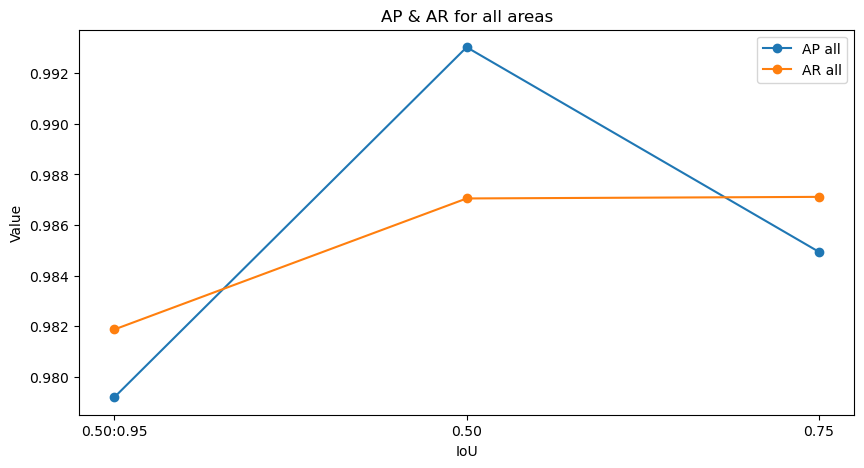

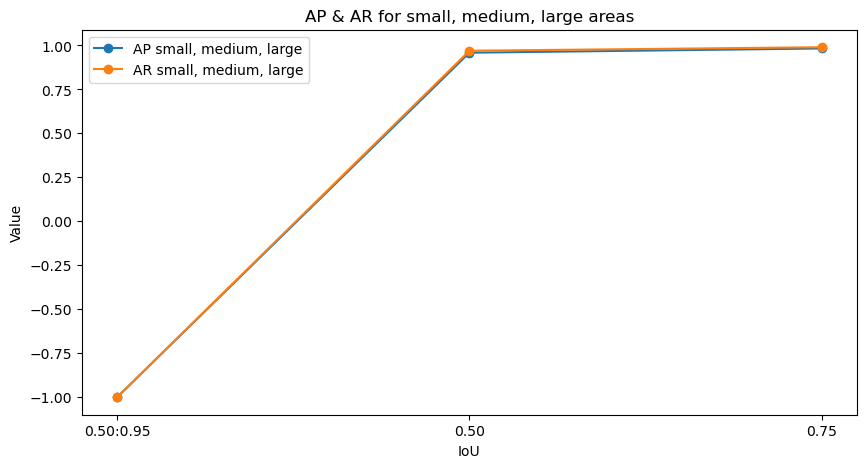

In [20]:
stats = coco_eval.stats

# Extracting stats
AP_all = stats[0:3]
AP_small_medium_large = stats[3:6]
AR_all = stats[6:9]
AR_small_medium_large = stats[9:12]

# Creating x values
IoU_values = ['0.50:0.95', '0.50', '0.75']

plt.style.use('default')

plt.figure(figsize=(10, 5))
plt.plot(IoU_values, AP_all, label='AP all', marker='o')
plt.plot(IoU_values, AR_all, label='AR all', marker='o')
plt.title('AP & AR for all areas')
plt.xlabel('IoU')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(IoU_values, AP_small_medium_large, label='AP small, medium, large', marker='o')
plt.plot(IoU_values, AR_small_medium_large, label='AR small, medium, large', marker='o')
plt.title('AP & AR for small, medium, large areas')
plt.xlabel('IoU')
plt.ylabel('Value')
plt.legend()
plt.show()

[ 0.97918378  0.99303278  0.98493597 -1.          0.95854755  0.98262496
  0.98186528  0.98704886  0.98711144 -1.          0.9696427   0.98974503]


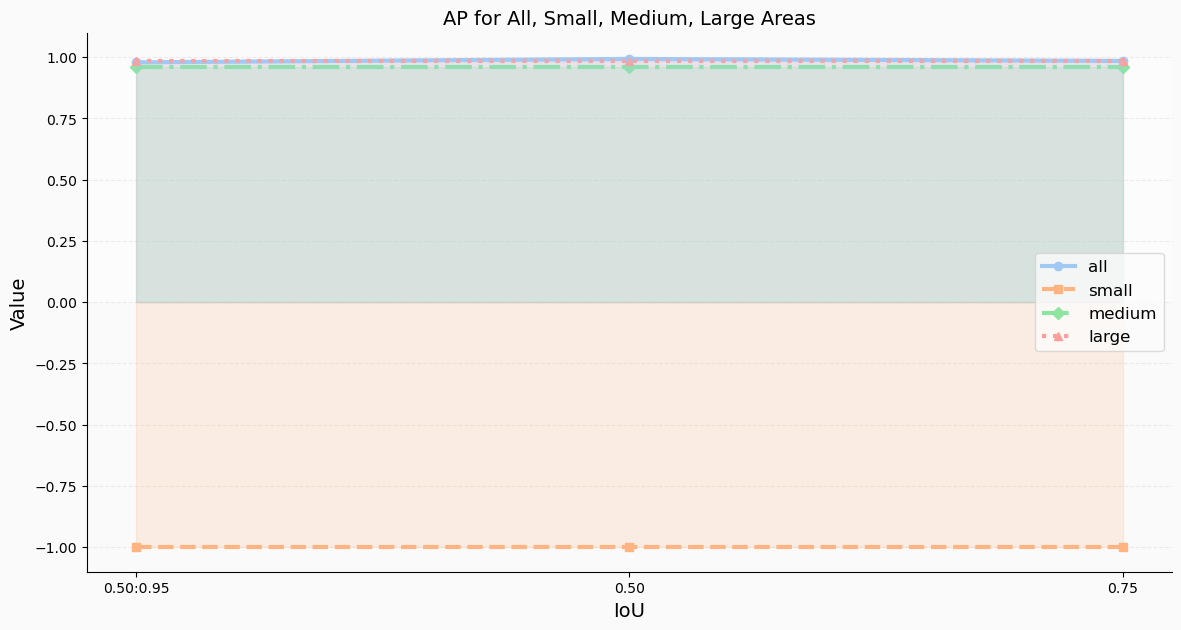

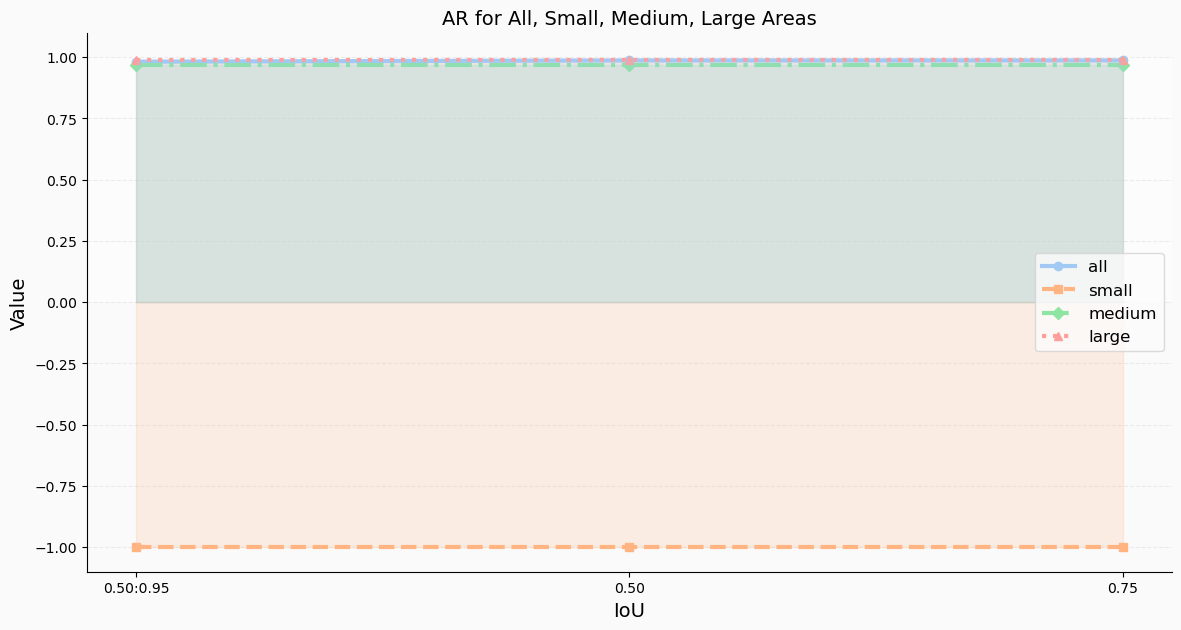

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Assuming stats is already defined somewhere in your code
stats = coco_eval.stats
print(stats)

# Extracting stats
AP_all = stats[0:3]
AP_small_medium_large = stats[3:6]
AR_all = stats[6:9]
AR_small_medium_large = stats[9:12]

# Creating x values
IoU_values = ['0.50:0.95', '0.50', '0.75']
types = ['all', 'small', 'medium', 'large']

# Preparing data for DataFrame
data = []
for i, IoU in enumerate(IoU_values):
    data.append([IoU, 'AP', AP_all[i], 'all'])
    data.append([IoU, 'AR', AR_all[i], 'all'])
    for t, type_str in enumerate(types[1:]):
        data.append([IoU, 'AP', AP_small_medium_large[t], type_str])
        data.append([IoU, 'AR', AR_small_medium_large[t], type_str])

# Creating DataFrame
df = pd.DataFrame(data, columns=['IoU', 'Metric', 'Value', 'Type'])

# Define custom markers and line styles
markers = ['o', 's', 'D', '^']
linestyles = ['-', '--', '-.', ':']

# Softer color palette
colors = sns.color_palette("pastel", 4)

# Function to plot data
def plot_data(metric):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Set background color
    fig.patch.set_facecolor('#fafafa')
    ax.set_facecolor('#fafafa')
    
    # Highlight the chart area
    ax.axhspan(ymin=0, ymax=1, xmin=0, xmax=1, facecolor='#fcfcfc')
    
    for idx, type_str in enumerate(types):
        subset = df[(df['Metric'] == metric) & (df['Type'] == type_str)]
        ax.plot(subset['IoU'], subset['Value'], marker=markers[idx], linestyle=linestyles[idx], color=colors[idx], label=type_str, lw=3)
        
        # Add gradient fill
        zorder = len(types) - idx
        ax.fill_between(subset['IoU'], subset['Value'], color=colors[idx], alpha=0.2, zorder=zorder)
        
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set grid with softer lines
    ax.yaxis.grid(color='lightgray', linestyle='dashed', alpha=0.4)
    
    # Set title and labels with customized styling
    ax.set_title(f'{metric} for All, Small, Medium, Large Areas', fontsize=14, loc='center', color='black')
    ax.set_xlabel('IoU', fontsize=14, color='black')
    ax.set_ylabel('Value', fontsize=14, color='black')
    
    # Set tick parameters
    ax.tick_params(axis='both', colors='black')
    
    # Add legend with specific styling and background box
    legend = ax.legend(loc='center right', fontsize=12, frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('#fcfcfc')
    frame.set_edgecolor('lightgray')
    for text in legend.get_texts():
        text.set_color('black')
    
    plt.show()

plot_data('AP')
plot_data('AR')